<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-dataset" data-toc-modified-id="Load-dataset-1">Load dataset</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2">EDA</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-3">Feature engineering</a></span><ul class="toc-item"><li><span><a href="#K-means-clustering" data-toc-modified-id="K-means-clustering-3.1">K-means clustering</a></span></li></ul></li></ul></div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [35]:
pd.set_option("display.max_columns", None)
pd.set_option("display.float", "{:.2f}".format)
warnings.filterwarnings(action='ignore')

In [4]:
# 한글폰트적용
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format = 'retina'

# Load dataset

In [5]:
data = pd.read_csv('Telco-Customer-Churn.csv')

In [6]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# EDA

In [7]:
print('No. observations: {}\nNo. Columns: {}'.format(data.shape[0], data.shape[1]))

No. observations: 7043
No. Columns: 21


In [8]:
pd.DataFrame({
    'Data type':data.dtypes,
    'No. unique values':data.nunique(),
    'No. missing values':data.isna().sum()
})

,Data type,No. unique values,No. missing values
customerID,object,7043,0
gender,object,2,0
SeniorCitizen,int64,2,0
Partner,object,2,0
Dependents,object,2,0
tenure,int64,73,0
PhoneService,object,2,0
MultipleLines,object,3,0
InternetService,object,3,0
OnlineSecurity,object,3,0


변수들의 이름, 데이터 타입, 각 변수들의 고유 값의 개수, 결측치를 확인해 줍니다.

In [9]:
data[pd.to_numeric(data['TotalCharges'], errors='coerce').isna()][['TotalCharges']]

,TotalCharges
488,
753,
936,
1082,
1340,
3331,
3826,
4380,
5218,
6670,


TotalCharges 변수는 고유값의 개수가 6531개 임에도 데이터 타입은 문자열로 취급되어 있어 무엇 때문인지 알아본 결과, 몇몇 개체들이 제대로 된 값을 가지고 있지 않음을 확인할 수 있습니다.
이 값들은 결측치로 취급한 후 데이터 타입을 수치형으로 바꾸어 줍니다.

In [10]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [11]:
data.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

11개의 새로운 결측치가 생겼습니다.

In [12]:
custid = ['customerID']
target = ['Churn']

# 범주형 변수
cat_cols = data.nunique()[data.nunique() < 10].keys().tolist()
cat_cols.remove(target[0])

# 수치형 변수
num_cols = [col for col in data.columns if col not in custid + target + cat_cols]

변수를 타겟 변수, 범주형 변수, 수치형 변수 등으로 구분지어 줍니다.

In [13]:
print('Distribution of the target variable of the data set')
data['Churn'].value_counts()

Distribution of the target variable of the data set


No     5174
Yes    1869
Name: Churn, dtype: int64

Text(0.5, 1.0, 'Distribution of Churn')

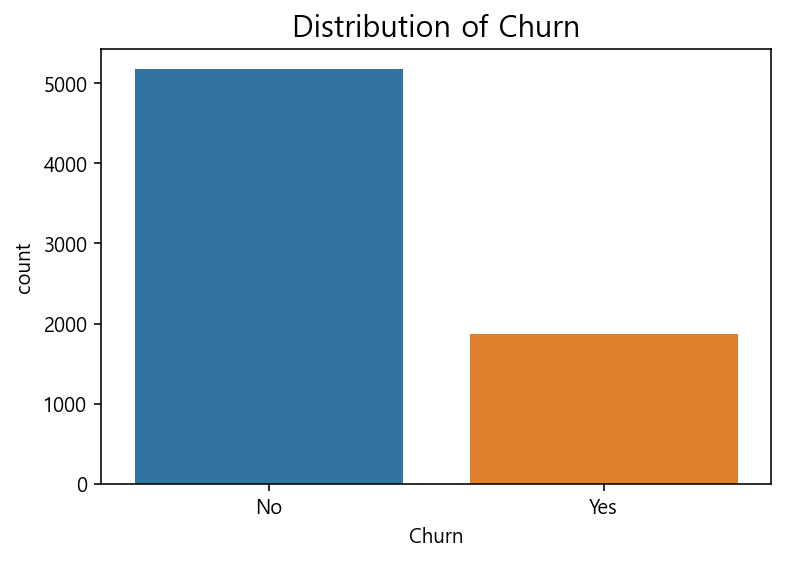

In [14]:
sns.countplot(x='Churn', data=data)
plt.title('Distribution of Churn', fontdict={'fontsize':15})

타겟변수의 분포를 확인해 본 결과 No가 Yes보다 많지만 데이터 불균형을 신경쓸 정도는 아니라 생각됩니다.

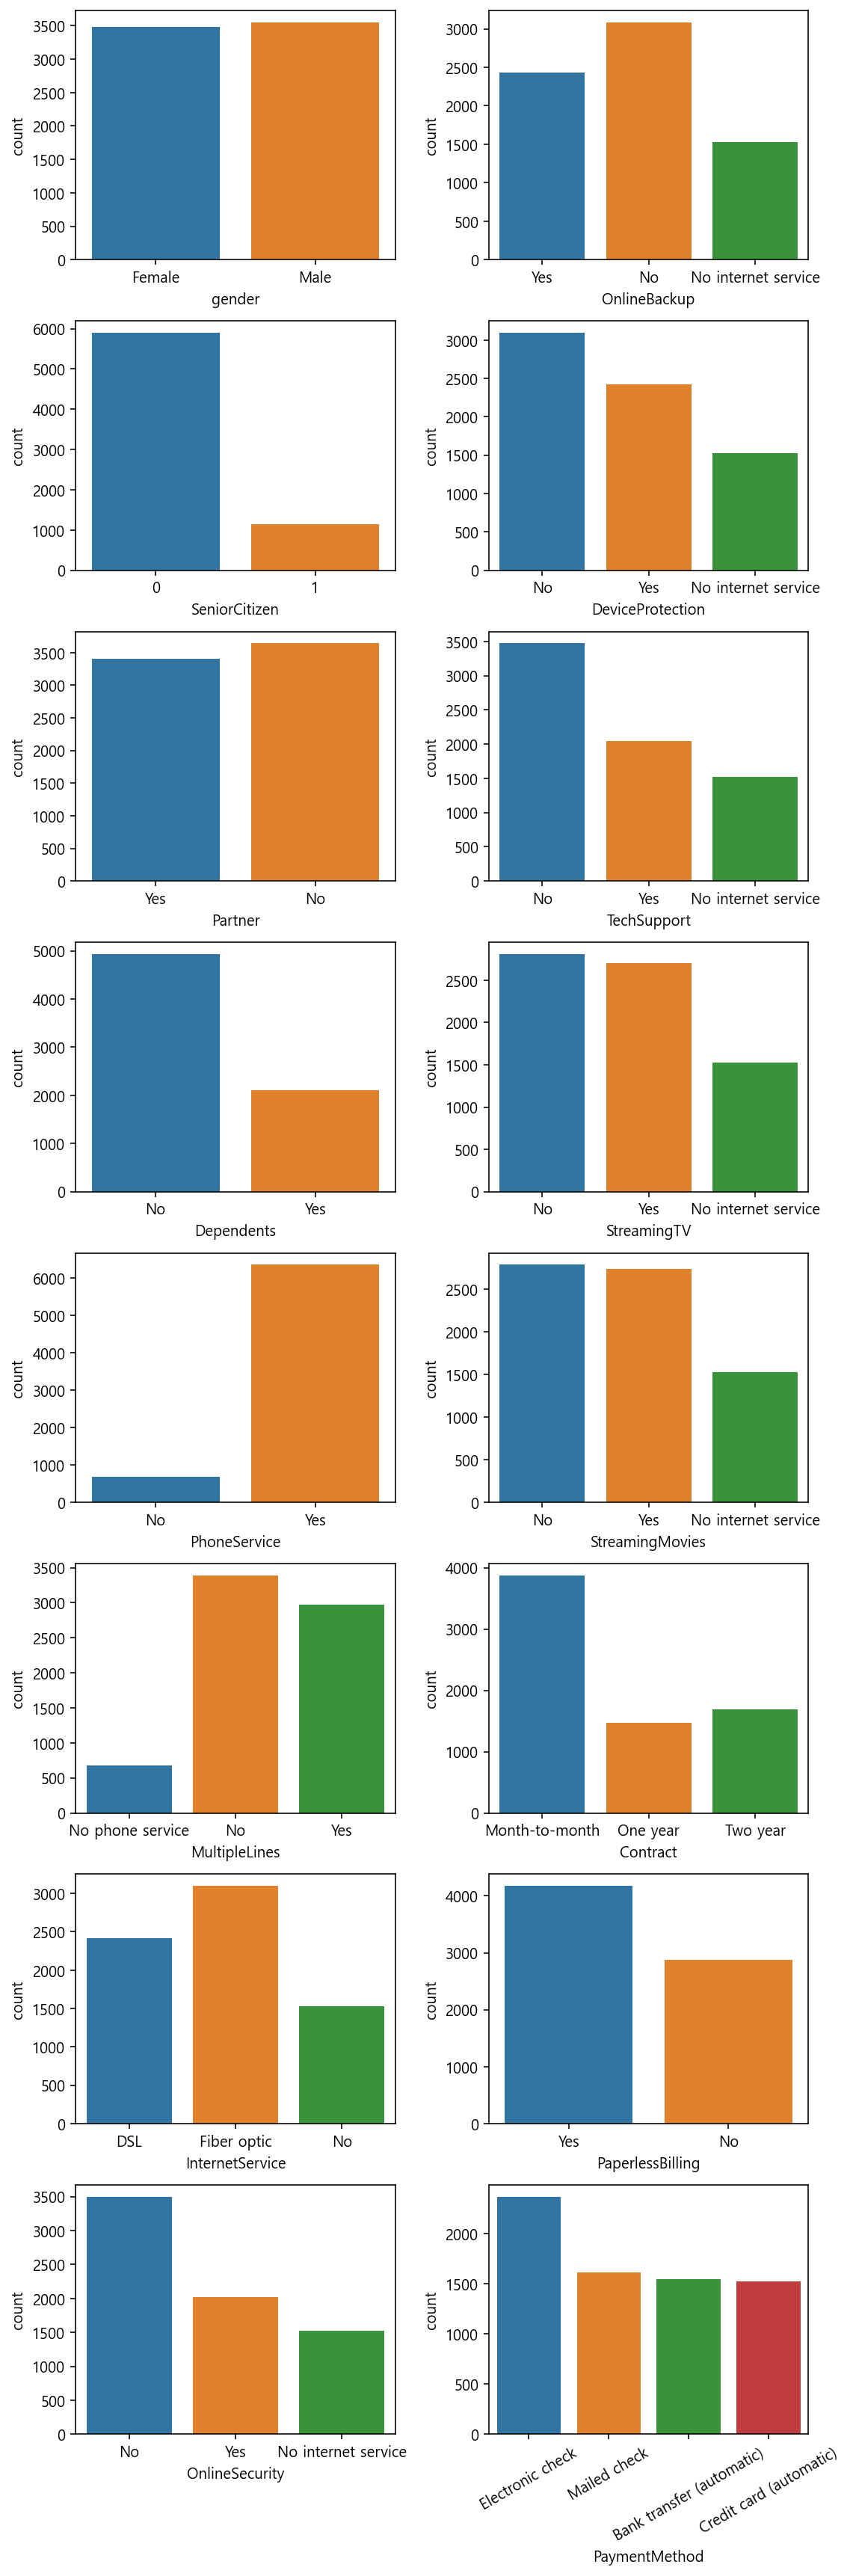

In [15]:
fig, axes = plt.subplots(8, 2, figsize = (8, 3*8))

for ind, col in enumerate(cat_cols):
    _ = sns.countplot(x=col, data=data, ax=axes[np.where(ind < 8, ind, ind-8), np.where(ind < 8, 0, 1)])
    _ = plt.xticks(rotation=30)
    
fig.tight_layout()

범주형 변수의 분포 형태를 알아보았습니다.

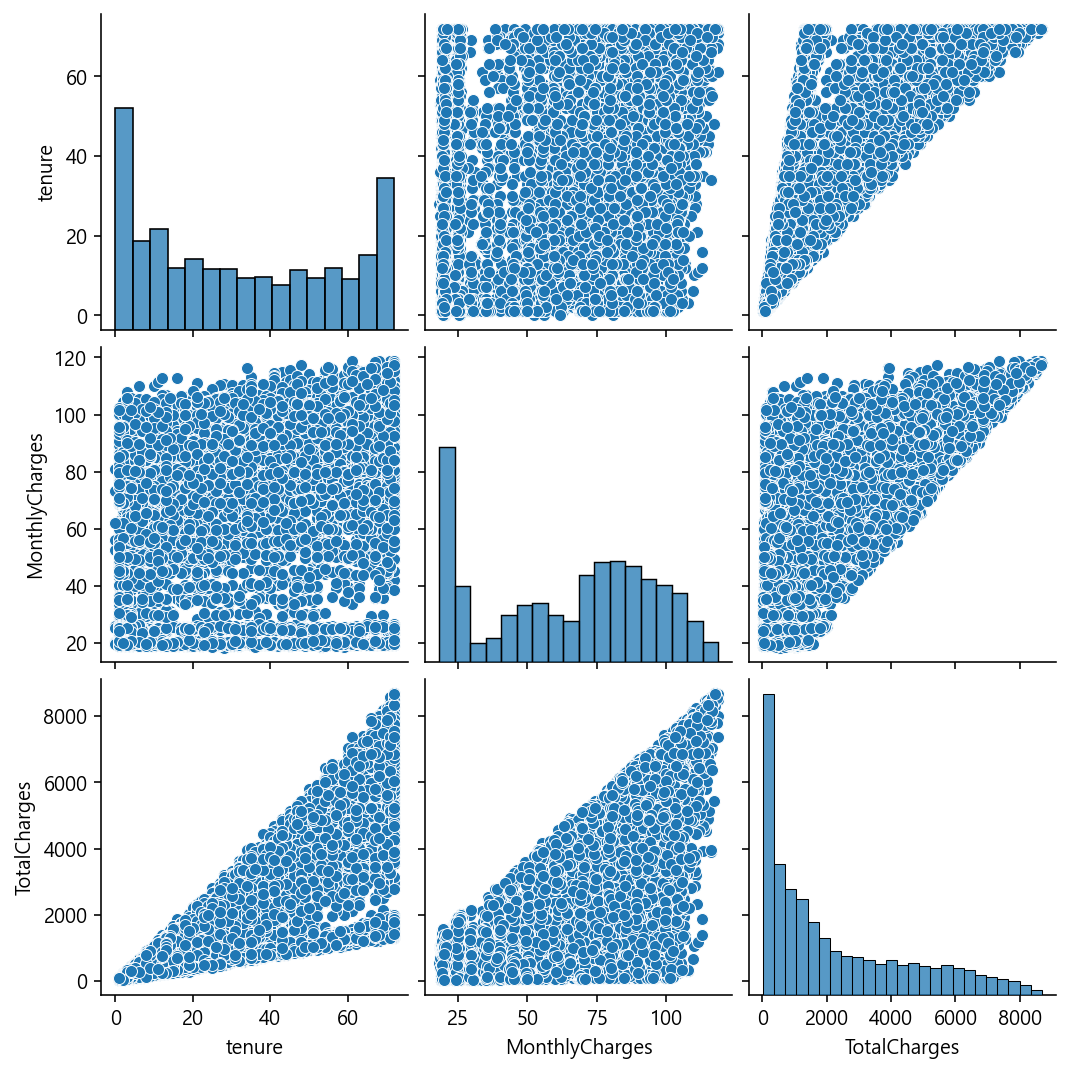

In [16]:
_ = sns.pairplot(data[num_cols])

수치형 변수들의 히스토그램과 Scatter plot을 통해 변수간 관계를 알아보았습니다. 변수 TotalCharges는 다른 변수들과 상관관계가 높은 것으로 보입니다.

<AxesSubplot:>

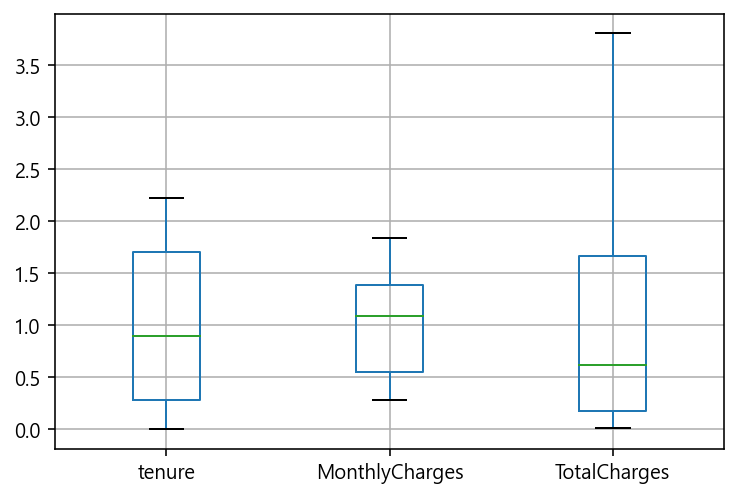

In [17]:
# 데이터 세트 정규화
normalized = data / data.mean()
normalized[num_cols].boxplot()

박스플롯을 통해 정규화 된 수치형 변수들의 분포를 확인합니다.

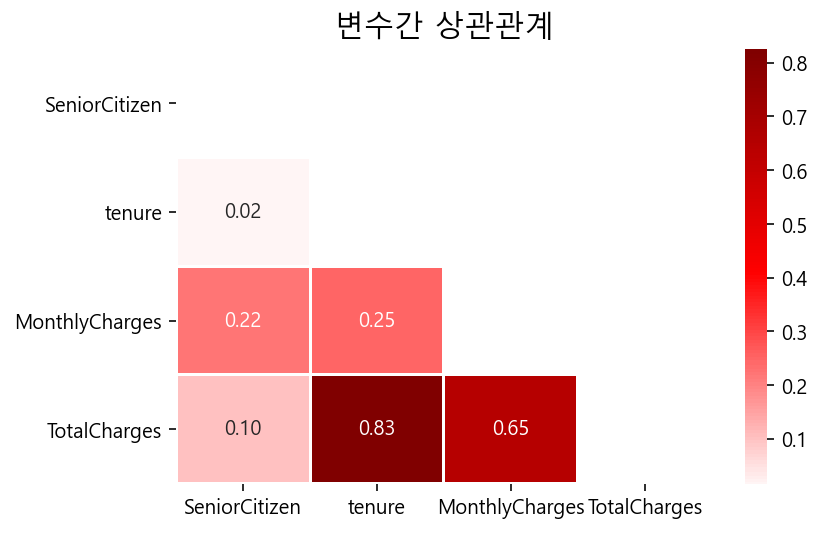

In [18]:
# 변수간 상관관계
corr = data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
_ = sns.heatmap(corr,
           mask = mask,
           annot = True,
           cmap = "seismic",
           center = 0,
           fmt = '.2f',
           linewidths=1)
_ = plt.title('변수간 상관관계', fontdict={'fontsize':15})

상관관계가 높은 변수들
>TotalCharges & tenure (0.83) <br>
TotalCharges & MonthlyCharges (0.65)

<br>
변수 TotalCharges는 다른 변수들과 높은 상관관계를 가져 다중공선성이 의심되므로 나중에 제거하도록 합니다.

# Feature engineering

In [19]:
data_mod = data.drop('TotalCharges', axis=1)
num_cols.remove('TotalCharges')

TotalCharges 변수를 제거하였습니다.

In [20]:
# 결측치 재확인
data_mod.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
Churn               0
dtype: int64

앞 전에 결측치를 가지고 있었던 TotalCharges 변수를 제거해 주어 데이터세트에는 더 이상 결측치를 가지고 있는 변수는 없습니다.

In [21]:
def ordinal_3(col):
    return np.where(col == 'Yes', 2, np.where(col == 'No', 1, 0))

In [22]:
# Ordinal encoding
ordinal3_cols =['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'PaperlessBilling']

for col in ordinal3_cols:
    data_mod[col] = data_mod[col].apply(ordinal_3)

In [23]:
data_mod['gender'] = np.where(data_mod['gender'] == 'Female', 1, 0)
data_mod['Churn'] = np.where(data_mod['Churn'] == 'Yes', 1, 0)

In [24]:
data_mod = pd.get_dummies(data_mod, columns=[col for col in cat_cols if col not in ordinal3_cols + ['gender', 'SeniorCitizen']], drop_first=True)

범주형 변수들 중 순서형 변수들은 Ordinal encoding을, 이외의 변수들은 One-hot encoding을 실행 하였습니다.

In [25]:
X = data_mod.drop(target + custid, axis=1)
y = data_mod[target[0]]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, stratify=y, random_state=802)

데이터를 Train set와 Test set으로 7:3 층화추출을 통해 분할하였습니다.

In [26]:
scaler = StandardScaler()

train_X_std = scaler.fit_transform(train_X)
test_X_std = scaler.transform(test_X)

변수들을 표준화하였습니다.

In [27]:
# 랜덤 포레스트
rf_selector = RandomForestClassifier(random_state=802)
rf_selector.fit(train_X_std, train_y)

print('-----------------------------------------------')
print('Model accuracy: ', round(accuracy_score(test_y, rf_selector.predict(test_X_std)), 3))

-----------------------------------------------
Model accuracy:  0.79


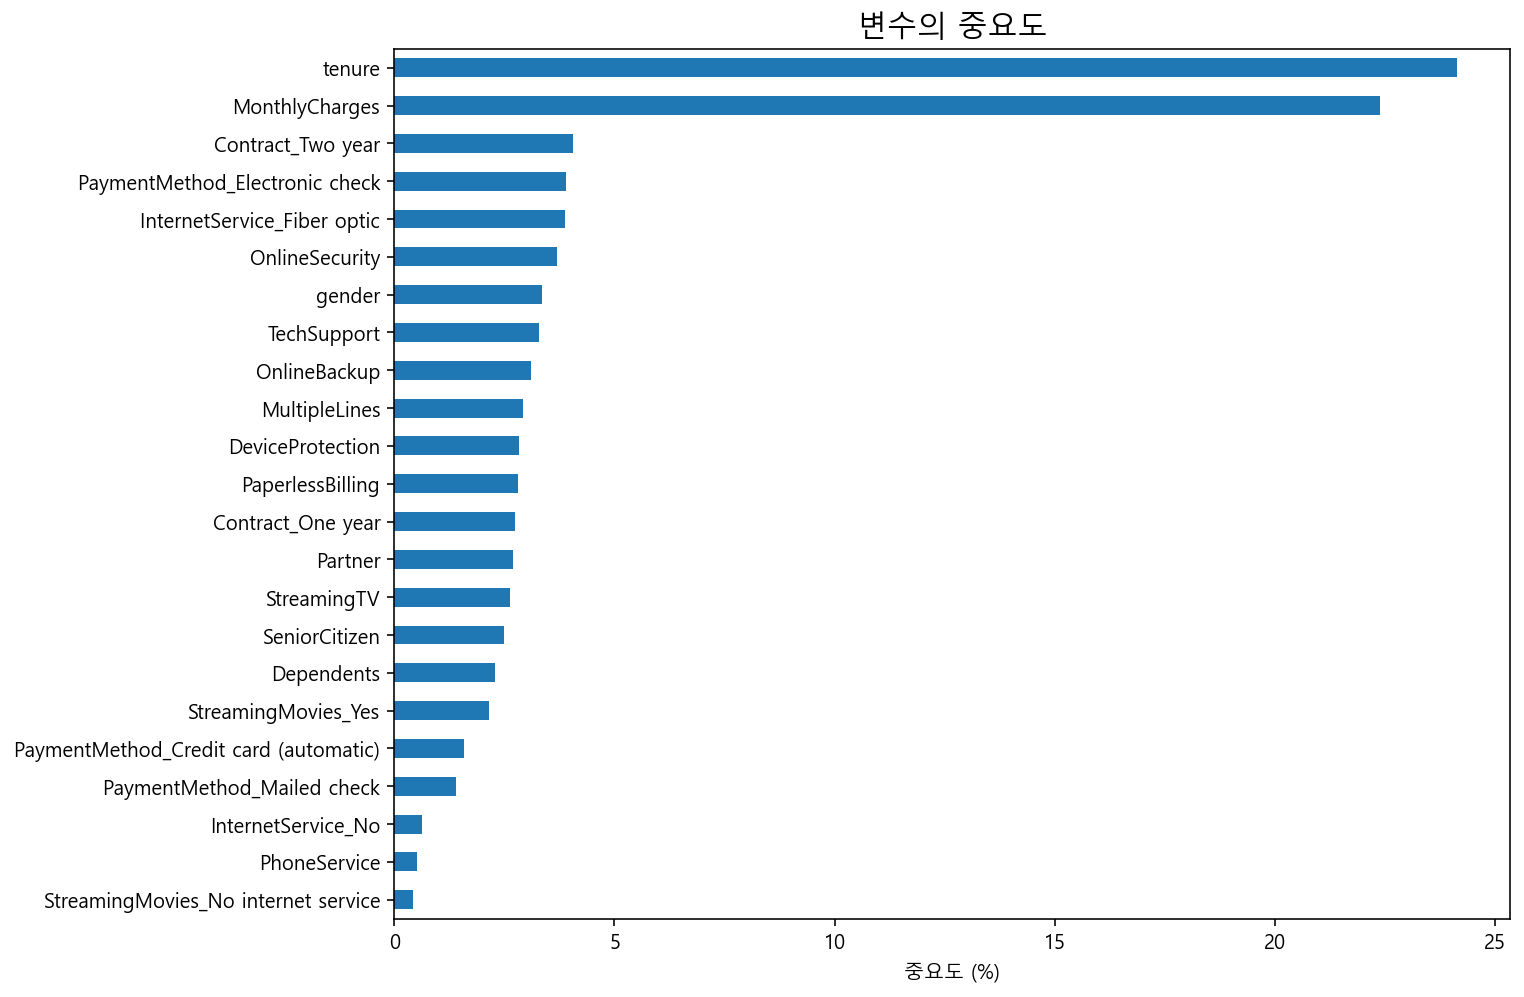

In [28]:
importance_rf = pd.Series(rf_selector.feature_importances_*100, index=train_X.columns).sort_values()

_ = plt.figure(figsize = (10, 8))
_ = importance_rf.plot(kind='barh')
_ = plt.title("변수의 중요도", fontdict={'fontsize':15})
_ = plt.xlabel('중요도 (%)')

In [29]:
importance_df = pd.DataFrame({
    '변수 중요도 (%)':rf_selector.feature_importances_ * 100
}, index=train_X.columns).sort_values('변수 중요도 (%)', ascending=False)

importance_df

,변수 중요도 (%)
tenure,24.14
MonthlyCharges,22.39
Contract_Two year,4.07
PaymentMethod_Electronic check,3.90
InternetService_Fiber optic,3.87
OnlineSecurity,3.70
gender,3.36
TechSupport,3.29
OnlineBackup,3.11
MultipleLines,2.93


랜덤 포레스트 머신러닝을 이용하여 변수들의 고객 이탈 여부에 영향을 끼치는 정도를 알아 본 결과, 변수 `tenure`와 `MonthlyCharges`가 이탈 여부를 예측하는 데 가장 중요한 변수임을 알 수 있습니다.

<AxesSubplot:>

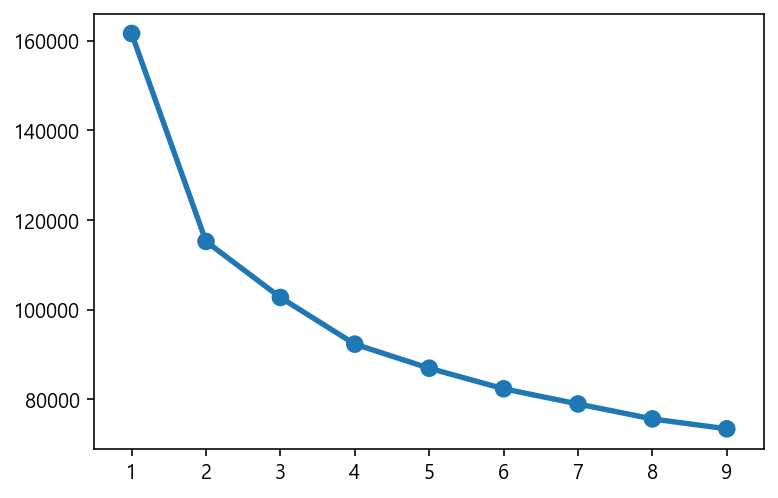

In [30]:
# K평균 군집분석

X_std = scaler.transform(X)

sse = {}
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=802, n_jobs=-1)
    km.fit(X_std)
    sse[k] = km.inertia_
    
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

In [31]:
km4 = KMeans(n_clusters=4, random_state=802)
km4.fit(X_std)

X_km = X.assign(segment = km4.labels_, Churn=y)

데이터에 대한 세부적인 탐색을 위하여 K평균 군집분석을 실시하였습니다.

In [61]:
# 유형별 평균수치

avg_by_segment_df = X_km.groupby('segment')[['tenure', 'MonthlyCharges', 'Churn']].mean().sort_values(by='Churn', ascending=False)

avg_by_segment_df.columns = ['이용기간 (개월)', '월 요금 ($)', '이탈률 (%)']
avg_by_segment_df['이탈률 (%)'] = avg_by_segment_df['이탈률 (%)'] * 100
avg_by_segment_df.index = [0, 1, 2, 3]
avg_by_segment_df.index.name = 'segment'

avg_by_segment_df.style\
    .set_caption('고객 유형별 주요 변수 평균')\
    .format('{:.2f}')

,이용기간 (개월),월 요금 ($),이탈률 (%)
segment,,,
0,16.12,75.28,47.98
1,31.74,42.03,24.93
2,54.41,89.94,13.62
3,30.55,21.08,7.40


K 평균 군집분석을 통해 통신사 고객 유형을 4가지로 나눌 수 있었습니다.
* 첫번째 유형: 평균 tenure(이용기간)은 약 16개월로 가장 짧고, 평균 MonthlyCharges(월 요금)이 약 75달러로 비교적 높은 유형으로 4가지 고객 유형 중 이탈률이 가장 높습니다.(평균 48%)
* 두번째 유형: 평균 이용기간과 월 평균 요금 모두 각각 약 30개월, 42달러로 중간 정도이며 이탈률은 평균 25%로 이탈률이 두번째로 높은 유형입니다.
* 세번째 유형: 평균 이용기간은 약 54개월로 4가지 유형 중 이용기간이 가장 길며, 월 평균 요금 또한 약 90달러로 가장 높은 유형 입니다. 평균 이탈률은 14%로 비교적 이탈률이 낮은 유형입니다.
* 네번째 유형: 평균 이용기간은 약 30개월로 중간 정도이지만, 월 평균 요금이 약 21달러로 4가지 유형 중 요금제가 가장 낮은 집단 입니다. 평균 이탈률은 약 7%로 4가지 고객 유형 중 이탈률이 가장 낮습니다.